In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# MEC6514 - Masse ajoutée

Ce document est un support au cours sur la masse ajoutée. Vous y retrouverez la démarche pour obtenir la masse ajoutée d'un cylindre circulaire, à l'aide de Python, ainsi que les formules pour d'autres formes plus complexes, fournies par Naudascher et Rockwell (1994).

## Masse ajoutée d'un cylindre circulaire

Pour pouvoir déterminer la masse ajoutée d'un cylindre circulaire, on applique la théorie des écoulements potentiels, qui nous permet de simplifier les équations de Navier-Stokes. Ceci amène les hypothèses suivantes :
- Fluide parfait ($R_e \rightarrow \infty$ et viscosité négligeable)
- Ecoulement irrotationnel (vorticité nulle)
- Fluide incompressible (hypothèse que l'on ajoute et non obligatoire)

Avant de décrire le cylindre, on importe les librairies de Python nécessaires :

In [4]:
# librairie et outils pour le calcul symbolique
from sympy import symbols,dsolve,diff,Function,lambdify
import sympy as sp

# librairie pour le calcul numérique
import numpy as np

# librairie pour les figures et tracés
import matplotlib.pyplot as plt

On considère un cylindre circulaire de rayon $a$ se déplaçant à la vitesse $U$ et l'accélération $\dot{U}$ dans un fluide au repos remplissant un domaine infini (de masse volumique $\rho$).

In [5]:
t = symbols('t') # permet de définir t comme une variable inconnue

# les paramètres suivants peuvent être changés à votre guise
a = 0.02         # rayon du cylindre (en m)
U = t+2          # Vitesse dépendant du temps, pour une accélération non nulle
rho = 1000       # masse volumique du fluide (en kg/m^3)

On définit les coordonnées comme cylindriques (ou polaires). Pour obtenir la masse ajoutée du cylindre, il faut déterminer dans un premier temps le champs de vitesse du fluide environnant. Pour cela, on définit les conditions limites :
- Condition de non-pénétration sur la paroi du cylindre :  
    à $r=a$, la vitesse radiale $u_r=U\cos{\theta}$
- Loin du cylindre, pas d'effet de celui-ci sur l'écoulement :  
    à $r=\infty$, la vitesse radiale $u_r=0$ et la vitesse azimutale $u_{\theta}=0$

On résout l'équation de Laplace en coordonnées cylindriques (et 2D), dont la solution est le potentiel de déplacement fluide $\phi(r,\theta)$ :
\begin{equation*}
\frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial\phi}{\partial r}\right) + \frac{1}{r^2} \frac{\partial^2\phi}{\partial\theta^2}= 0
\end{equation*}
Pour résoudre cette équation, on applique la méthode de séparation des variables : $\phi(r,\theta) = R(r)T(\theta)$, ce qui nous donne :
\begin{equation*}
\frac{r}{R(r)}\frac{\partial}{\partial r}\left(r \frac{\partial R}{\partial r}\right)=-\frac{1}{T(\theta)} \frac{\partial^2 T}{\partial\theta^2}
\end{equation*}
Les termes $R(r)$ et $T(\theta)$ étant indépendants, chaque côté de l'expression est égal à une constante. En posant cette constante égale à $1$, on obtient deux équations découplées, qu'il nous est possible de résoudre avec Python :
\begin{equation*}
\frac{\partial^2 T}{\partial\theta^2}+T(\theta)=0 \textrm{ et }r^2 \frac{\partial^2 R}{\partial r^2} +r \frac{\partial R}{\partial r} - R(r) = 0
\end{equation*}

In [6]:
theta = symbols('theta')
T = Function('T')(theta) # on introduit T la fonction symbolique d'argument theta

# dsolve résoud des EDO et diff est l'opérateur différentiel symbolique
T_theta = dsolve(diff(diff(T,theta),theta)+T,T).args[1]
print('T(theta) = ',T_theta)

T(theta) =  C1*sin(theta) + C2*cos(theta)


On procède de la même manière avec $R(r)$ :

In [7]:
r = symbols('r')
R = Function('R')(r)

R_r = dsolve(r**2*diff(diff(R,r),r)+r*diff(R,r)-R,R).args[1]
print(' R(r) = ',R_r)

 R(r) =  C1/r + C2*r


On applique ensuite les conditions limites pour déterminer les constantes inconnues :  
- $r = \infty$, $u_r=0$ $\rightarrow$ $C_2^r=0$
- $r = \infty$, $u_{\theta}=0$ $\rightarrow$ $C_2^{\theta}=C_1^{\theta}\tan{\theta}$
- $r=a$, $u_r=U\cos{\theta}$ $\rightarrow$ $2 C_1^r C_1^{\theta} = -a^2 U$
  
Soit :
\begin{equation*}
\phi=-\frac{a^2}{r} U\cos{\theta}
\end{equation*}
Et :
\begin{equation*}
u_r = \frac{\partial\phi}{\partial r}=\frac{a^2}{r^2} U\cos{\theta} \textrm{, } u_{\theta} = \frac{1}{r}\frac{\partial\phi}{\partial\theta}=\frac{a^2}{r^2} U\sin{\theta}
\end{equation*}

On peut maintenant tracer les lignes de courant autour du cylindre. Ce dernier étant en accélération, il est nécessaire de choisir un instant auquel on effectue le tracé. On a arbitrairement choisi l'instant initial $t=0$, mais vous pouvez changer celui-ci.

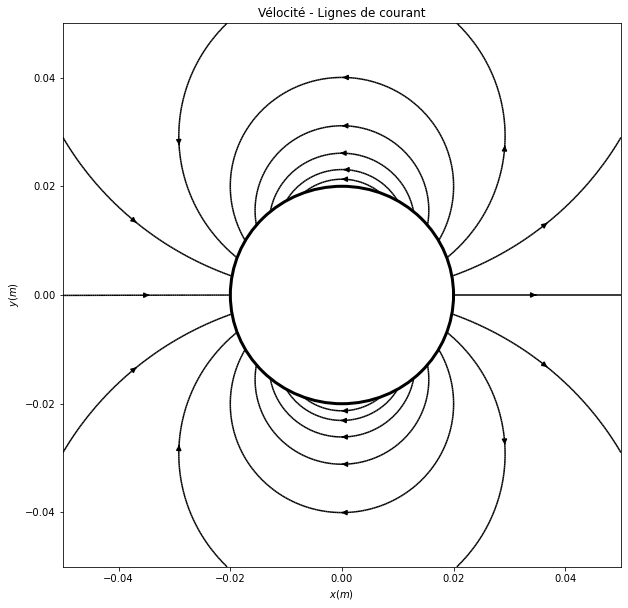

In [8]:
U_0 = lambdify(t,U)(0) # changement d'instant à effectuer ici
phi = -a**2/r*U_0*sp.cos(theta)

# vitesse radiale
ur = lambdify((r,theta),diff(phi,r)) # passage d'une expression symbolique à une fonction numérique

# vitesse tangentielle (ou azimutale)
utheta = lambdify((r,theta),1/r*diff(phi,theta))

''' Calcul du champs de vitesse en coordonnées cartésiennes pour tracer '''
Ux = np.zeros((int(round(5*a*1000,0))+1,int(round(5*a*1000,0))+1))
Vy = np.zeros((int(round(5*a*1000,0))+1,int(round(5*a*1000,0))+1))

# x1 -> y et x2 -> x
x1,x2 = np.arange(-2.5*a,2.5*a+0.001,0.001), np.arange(-2.5*a,2.5*a+0.001,0.001)
i = 0
while i < int(round(5*a*1000,0))+1:
    j = 0
    while j < int(round(5*a*1000,0))+1:
        # calcul des coordonnées cylindriques
        r = np.sqrt((x1[i])**2+(x2[j])**2)
        theta = np.arcsin(x1[i]/np.sqrt((x1[i])**2+(x2[j])**2))
        if r>a:
            if x1[i] > 0 and x2[j] > 0:
                # quadrant supérieur droit
                Ux[i,j] = ur(r,theta)*np.cos(theta)-utheta(r,theta)*np.sin(theta)
                Vy[i,j] = ur(r,theta)*np.sin(theta)+utheta(r,theta)*np.cos(theta)
            elif x1[i] > 0 and x2[j] < 0:
                # quadrant supérieur gauche
                Ux[i,j] = -ur(r,np.pi-theta)*np.cos(theta)-utheta(r,np.pi-theta)*np.sin(theta)
                Vy[i,j] = ur(r,np.pi-theta)*np.sin(theta)-utheta(r,np.pi-theta)*np.cos(theta)
            elif x1[i] < 0 and x2[j] < 0:
                # quadrant inférieur gauche
                Ux[i,j] = -ur(r,np.pi-theta)*np.cos(theta)-utheta(r,np.pi-theta)*np.sin(theta)
                Vy[i,j] = ur(r,np.pi-theta)*np.sin(theta)-utheta(r,np.pi-theta)*np.cos(theta)
            elif x1[i] < 0 and x2[j] > 0:
                # quadrant inférieur droit
                Ux[i,j] = ur(r,theta)*np.cos(theta)-utheta(r,theta)*np.sin(theta)
                Vy[i,j] = ur(r,theta)*np.sin(theta)+utheta(r,theta)*np.cos(theta)
        j += 1
    i += 1
            
''' Tracé des lignes de courant '''
X1,X2 = np.meshgrid(x1,x2)
s_p_init = [(a*np.cos(i),a*np.sin(i)) for i in np.linspace(0,2*np.pi,36+1)] 
s_p = s_p_init[:8]+s_p_init[11:25]+s_p_init[29:-1] # sélection des points de départ des lignes de courant
cylinder = plt.Circle((0, 0),a,ec='k',fc='w',lw=3,zorder=10) # définition du cylindre

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.streamplot(X1,X2,Ux,Vy,color='k',density=10,start_points=s_p)
ax.add_patch(cylinder)
ax.set_xlim(-2.5*a,2.5*a)
ax.set_ylim(-2.5*a,2.5*a)
ax.set_xlabel('$x (m)$')
ax.set_ylabel('$y (m)$')
ax.set_title('Vélocité - Lignes de courant')
plt.show()

Le potentiel de déplacement fluide $\phi$ étant déterminé, on évalue la distribution de la pression $p$ avec l'équation d'Euler :
\begin{equation*}
\rho\frac{\partial\phi}{\partial t} + \rho\frac{1}{2}\left(\overrightarrow{\nabla}\phi\right)^2+p=0
\end{equation*}

In [18]:
# on rédéfinit symboliquement ces variables car elles ont été utilisées précédemment
a,r,theta,rho,U,U_point = symbols('a r theta rho U U_point')
phi = -a**2/r*U*sp.cos(theta)
dphi_dt = -a**2/r*U_point*sp.cos(theta)

grad_phi = np.array([[diff(phi,r)],[1/r*diff(phi,theta)]]) # définition du gradient de phi
p = sp.simplify(-(rho*dphi_dt+rho*1/2*np.dot(grad_phi.T,grad_phi)))
p = p[0,0]
print('p = ',p)

p =  -U**2*a**4*rho/(2*r**4) + U_point*a**2*rho*cos(theta)/r


On calcule la force exercée par le fluide sur le cylindre en intégrant la pression sur la surface du cylindre :
\begin{equation*}
F_x = \int\limits^{2\pi}_0 pa\cos{\theta}d\theta \textrm{, en }r=a
\end{equation*}

In [10]:
Fx = sp.integrate(p*a*sp.cos(theta),(theta,0,2*sp.pi))
Fx = sp.nsimplify(Fx,tolerance=1e-10).subs(r,a)
print('Fx = ',Fx)

Fx =  pi*U_point*a**2*rho


Ce qui nous permet de déterminer la masse ajoutée du cylindre par unité de longueur $m_f$ avec $F_x=m_f\dot{U}$.

In [11]:
mf = Fx/U_point
print('Expression de mf : ',mf)

mf = mf.subs([(sp.pi,np.pi),(a,0.02),(rho,1000)]) # on remplace les variables par leur valeur, vous pouvez les modifier
print('mf = ',mf)

Expression de mf :  pi*a**2*rho
mf =  1.25663706143592


$A_{xx}$ (respectivement $A_{yy}$) est la contribution du mouvement du cylindre dans la direction $x$ (respectivement $y$) à la masse ajoutée dans la direction $x$ (respectivement $y$). Les deux sont égales pour le cylindre circulaire et c'est leur valeur que l'on vient de calculer.
Pour le cas du cylindre circulaire, la contribution du mouvement dans la direction $y$ à la
masse ajoutée dans la direction $x$ $A_{xy}$ est nul.  
  
Il nous est possible de calculer ces termes pour d'autres formes, dont les expressions ont été évaluées par Naudascher et Rockwell (1994).

Les formes suivantes sont centrées en $(0,0)$, c'est pour cela que chaque paramètre demandé est la moitié de la longueur habituellement utilisée. De plus, pour certaines formes, les ratios entre paramètres sont limités, car nous utilisons les résultats (parfois expérimentaux) fournis par Naudascher et Rockwell (1994). Vous êtes libres de modifier les paramètres pour calculer la masse ajoutée associée.

## Masse ajoutée d'une ellipse

In [12]:
a = 0.02   # demi grand-axe (en m)
b = 0.01   # demi petit-axe (en m)
rho = 1000 # masse volumique du fluide (en kg/m3)

print('Axx = ',rho*np.pi*b**2)
print('Ayy = ',rho*np.pi*a**2)
print('Axy = ',rho*np.pi/8*(a**2-b**2)**2)

Axx =  0.3141592653589793
Ayy =  1.2566370614359172
Axy =  3.534291735288518e-05


## Masse ajoutée d'un rectangle

In [13]:
a = 0.02   # demie largeur (en m)
a_b = 0.2  # ratio de la demie largeur sur la demie hauteur (en m) - à choisir parmi 0.1,0.2,0.5,1.0,2.0,5.0
rho = 1000 # masse volumique du fluide (en kg/m3)

b = a/a_b
if a_b == 0.1:
    alpha = 2.23
    alpha2 = 0.147
elif a_b == 0.2: 
    alpha = 1.98
    alpha2 = 0.15
elif a_b == 0.5:
    alpha = 1.7
    alpha2 = 0.15
elif a_b == 1:
    alpha = 1.51
    alpha2 = 0.234
elif a_b == 2:
    alpha = 1.36
    alpha1 = 0.15
    alpha2 = 0
elif a_b == 5:
    alpha = 1.21
    alpha1 = 0.15
    alpha2 = 0
    
print('Ayy = ',alpha*rho*np.pi*a**2)
if alpha2 != 0:
    print('Axy = ',alpha2*rho*np.pi*a**4)
else:
    print('Axy = ',alpha1*rho*np.pi*b**4)

Ayy =  2.4881413816431164
Axy =  7.539822368615503e-05


## Masse ajoutée d'une plaque

L'épaisseur de la plaque est considérée négligeable devant sa demie largeur.

In [14]:
a = 0.02   # demie largeur de la plaque (en m)
rho = 1000 # masse volumique du fluide (en kg/m3)

print('Axx = 0')
print('Ayy = ',rho*np.pi*a**2)
print('Axy = ',rho*np.pi/8*a**4)

Axx = 0
Ayy =  1.2566370614359172
Axy =  6.283185307179586e-05


## Masse ajoutée d'un losange

In [15]:
a = 0.02   # demie largeur (en m)
a_b = 0.2  # ratio de la demie largeur sur la demie hauteur (en m) - à choisir parmi 0.2,0.5,1.0,2.0
rho = 1000 # masse volumique du fluide (en kg/m3)

b = a/a_b
if a_b == 0.2:
    alpha = 0.61
elif a_b == 0.5:
    alpha = 0.67
elif a_b == 1:
    alpha = 0.76
elif a_b == 2.0:
    alpha = 0.85

print('Ayy = ',alpha*rho*np.pi*a**2)

Ayy =  0.7665486074759096


## Masse ajoutée d'une poutre en I

In [16]:
a = 0.02   # demie largeur de la poutre (en m)
rho = 1000 # masse volumique du fluide (en kg/m3)

# tiré des expériences de Naudascher et Rockwell
d = a/2.6
b = d/3.6

print('Ayy = ',2.11*rho*np.pi*a**2)

Ayy =  2.6515041996297852


## Masse ajoutée d'une poutre en croix

In [17]:
a = 0.02   # taille d'une branche (en m)
rho = 1000 # masse volumique du fluide (en kg/m3)

print('Axx = ', rho*np.pi*a**2)
print('Axy = ',rho*2/np.pi*a**2)

Axx =  1.2566370614359172
Axy =  0.25464790894703254
